In [37]:
#Visualization and numerical processing
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import yfinance as yf
import requests
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

# Statsmodels for time series analysis
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Sklearn for metrics and parameter grid
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

# Disable warnings and logging
#warnings.filterwarnings("ignore")
#logging.disable(logging.CRITICAL)

pd.set_option('display.max_rows',60000)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_colwidth',200)
pd.options.display.float_format = '{:,.4f}'.format

# Individual Stock

In [27]:
stock_data_ = pd.read_csv("dataset_0222.csv")
stock_data_['date'] = pd.to_datetime(stock_data_['date'],utc=False)
stock_data_['date'] = stock_data_['date'].dt.tz_localize(None)

In [53]:
len(stock_data_.columns)

92

In [57]:
stock_data_.dividends.unique()

array([0., 1.])

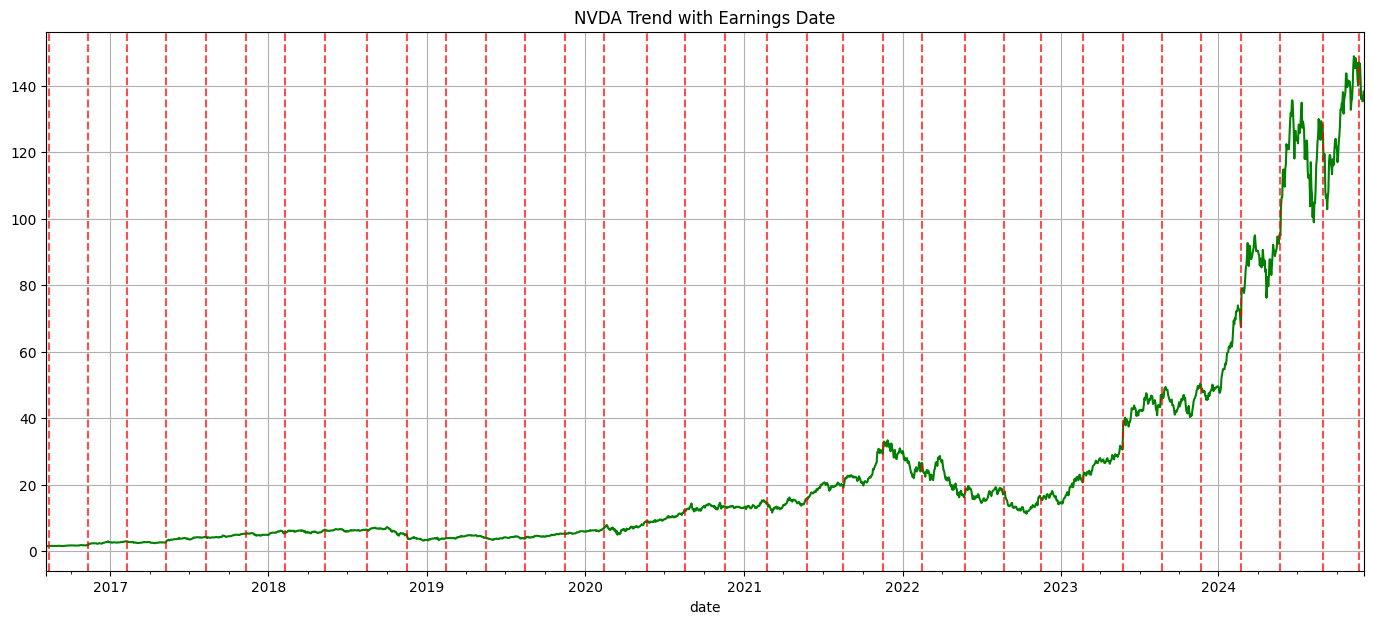

In [28]:
eg_ticker = 'NVDA'

# Filter and prepare the data
nvda_trend = stock_data_[stock_data_['ticker_id'] == eg_ticker].reset_index(drop=True)
nvda_trend_1 = nvda_trend[['date', 'close', 'earnings_date_flag']].copy()
nvda_trend_1 = nvda_trend_1.set_index(nvda_trend_1['date'])
div_dates = nvda_trend_1[nvda_trend_1['earnings_date_flag'] != 0].index

# Plot the closing price
fig, ax = plt.subplots(figsize=(17, 7))
nvda_trend_1['close'].plot(c='g', grid=True, ax=ax, title=f'{eg_ticker} Trend with Earnings Date')

# Add vertical lines for dividend dates
for div_date in div_dates:
    ax.axvline(x=div_date, color='r', linestyle='--', alpha=0.7, label='Earnings Date')

plt.show()

In [29]:
def plot_earnings_trend( ticker):
    stock_trend = stock_data_[stock_data_['ticker_id'] == ticker].reset_index(drop=True)
    stock_trend = stock_trend[['date', 'close', 'earnings_date_flag']].copy()
    stock_trend['date'] = pd.to_datetime(stock_trend['date'])
    stock_trend = stock_trend.set_index('date')
    earnings_dates = stock_trend[stock_trend['earnings_date_flag'] != 0].index
    
    fig, ax = plt.subplots(figsize=(17, 7))
    stock_trend['close'].plot(c='g', grid=True, ax=ax, title=f'{ticker} Trend with Earnings Date')
    
    for earnings_date in earnings_dates:
        ax.axvline(x=earnings_date, color='r', linestyle='--', alpha=0.7)
    
    plt.show()


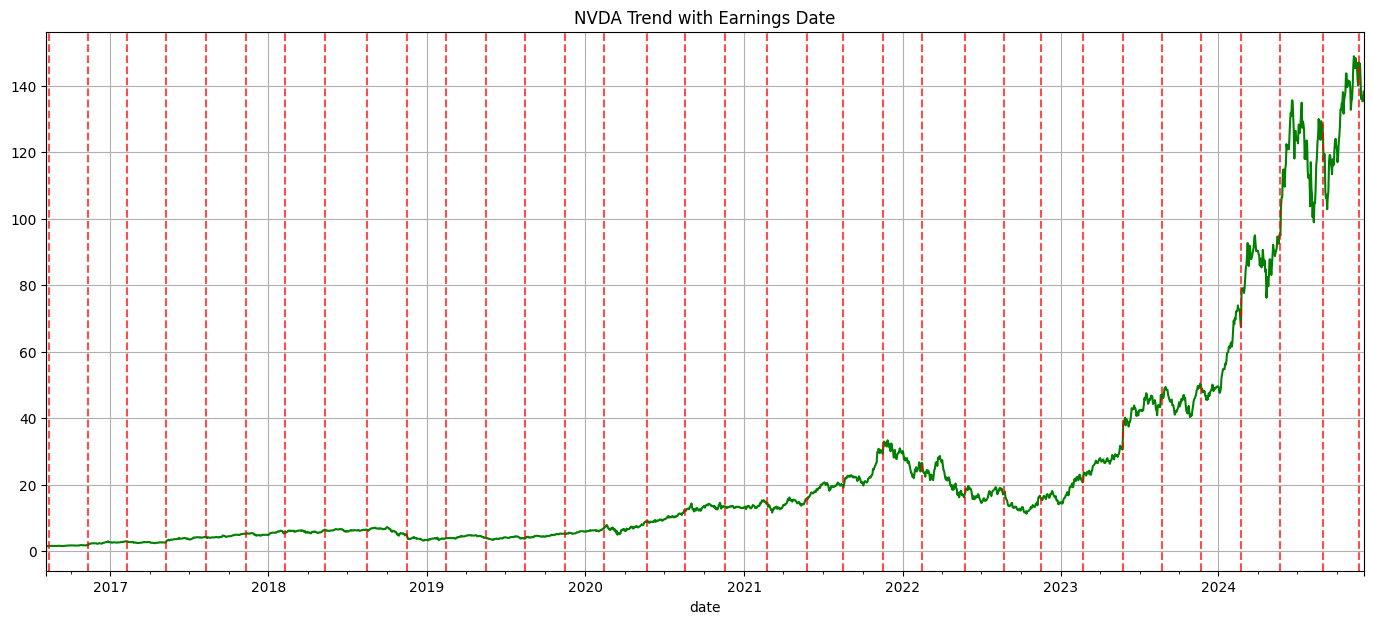

In [54]:
plot_earnings_trend( 'NVDA')

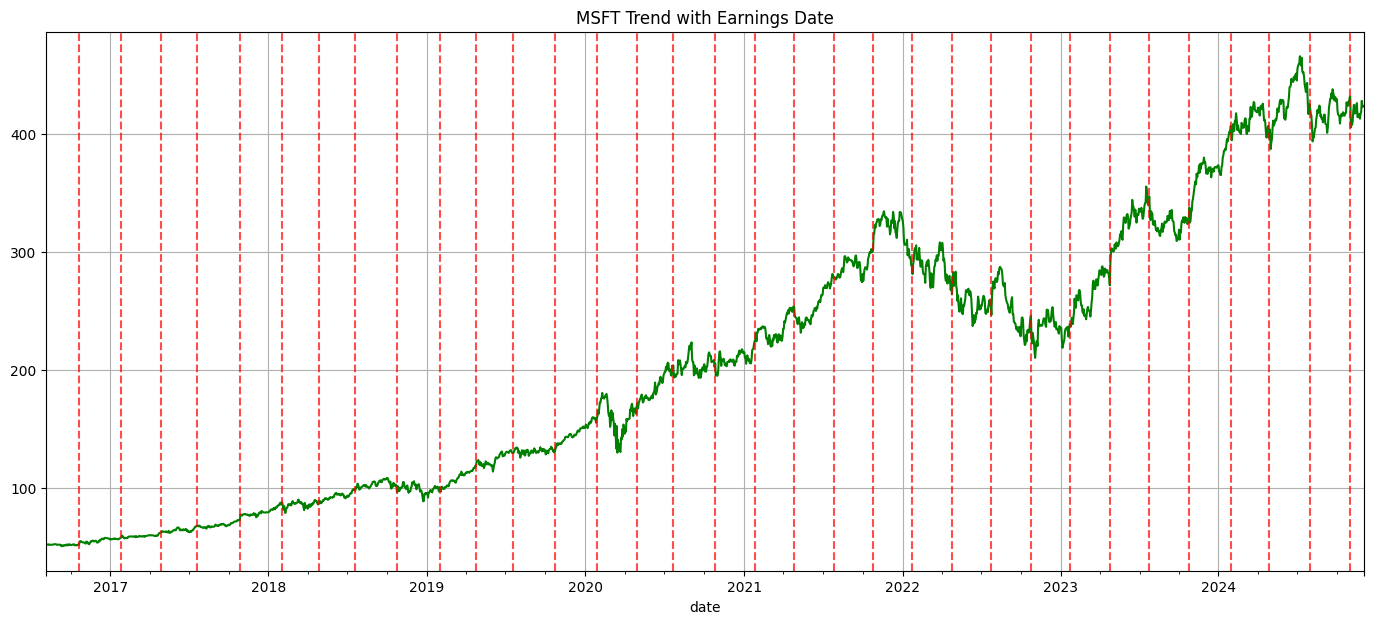

In [31]:
plot_earnings_trend( 'MSFT')

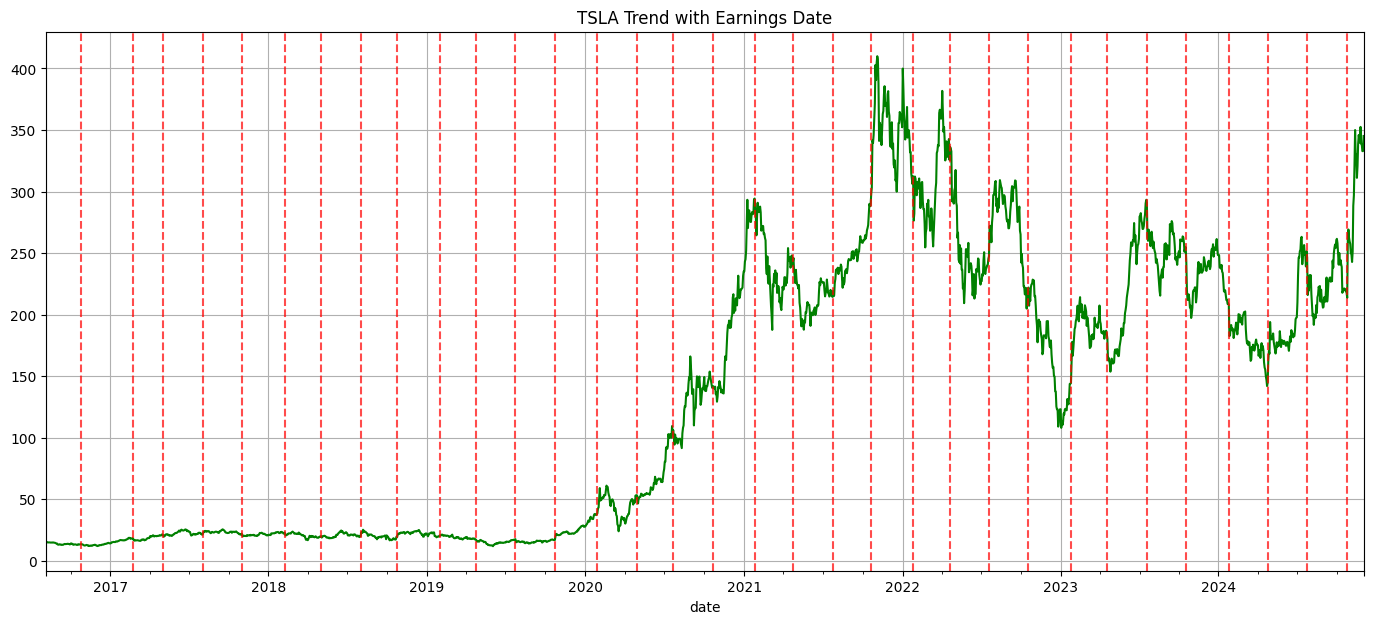

In [33]:
plot_earnings_trend( 'TSLA')

In [49]:
def sector_correlation_analysis(stock_data):
    sector_avg_trends = stock_data.groupby(['sector', 'date'])['close'].mean().unstack()
    correlation_matrix = sector_avg_trends.T.corr()
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Sector-Wise Correlation of Average Stock Prices')
    plt.show()

def pca_analysis_1(stock_data):
    stock_pivot = stock_data.pivot(index='date', columns='ticker_id', values='close').pct_change().dropna()
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(stock_pivot.fillna(0))
    explained_variance = np.sum(pca.explained_variance_ratio_)

    plt.figure(figsize=(8, 5))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
    plt.title(f'PCA of Stock Price Movements (Explained Variance: {explained_variance:.2f})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()


def hierarchical_clustering(stock_data):
    stock_pivot = stock_data.pivot(index='date', columns='ticker_id', values='close').pct_change().dropna()
    linkage_matrix = linkage(stock_pivot.T.fillna(0), method='ward')
    
    plt.figure(figsize=(12, 5))
    dendrogram(linkage_matrix, labels=stock_pivot.columns, leaf_rotation=90)
    plt.title('Hierarchical Clustering of Stocks Based on Price Movements')
    plt.show()

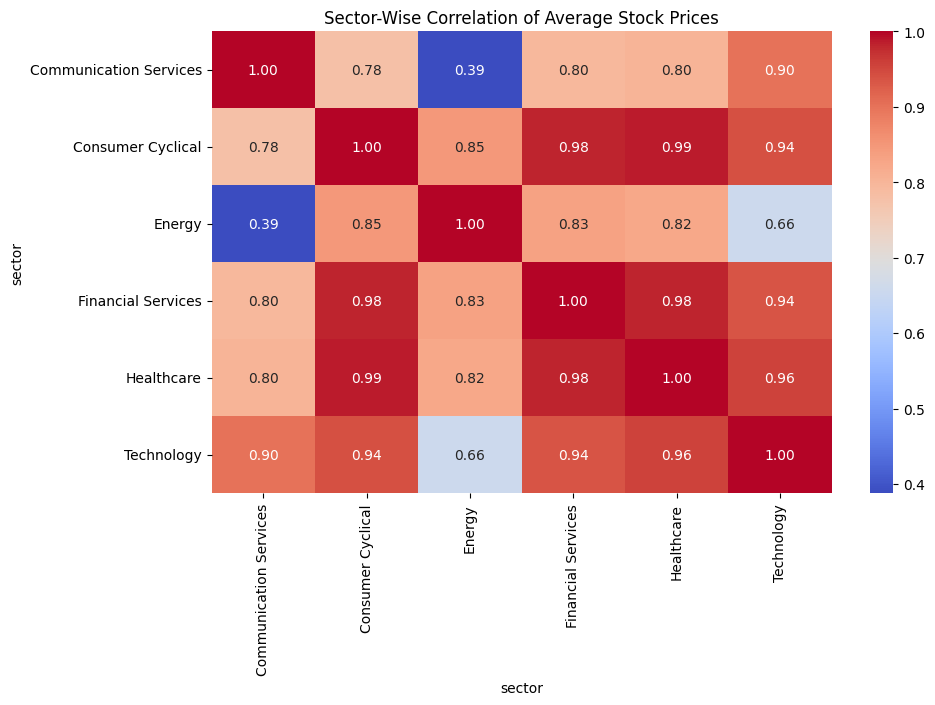

In [39]:
sector_correlation_analysis(stock_data_)

In [47]:
def pca_analysis(stock_data):
    stock_pivot = stock_data.pivot(index='date', columns='ticker_id', values='close').pct_change().dropna()
    sectors = stock_data[['ticker_id', 'sector']].drop_duplicates().set_index('ticker_id')

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(stock_pivot.fillna(0))
    explained_variance = np.sum(pca.explained_variance_ratio_)

    plt.figure(figsize=(8, 5))

    # Map tickers to sector colors
    unique_sectors = sectors['sector'].unique()
    sector_colors = {sector: color for sector, color in zip(unique_sectors, sns.color_palette("hsv", len(unique_sectors)))}
    
    for ticker_idx, ticker in enumerate(stock_pivot.columns):
        sector = sectors.loc[ticker, 'sector']
        plt.scatter(pca_result[ticker_idx, 0], pca_result[ticker_idx, 1], 
                    color=sector_colors[sector], label=sector if ticker_idx == 0 else "", alpha=0.6)

    plt.title(f'PCA of Stock Price Movements (Explained Variance: {explained_variance:.2f})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.show()

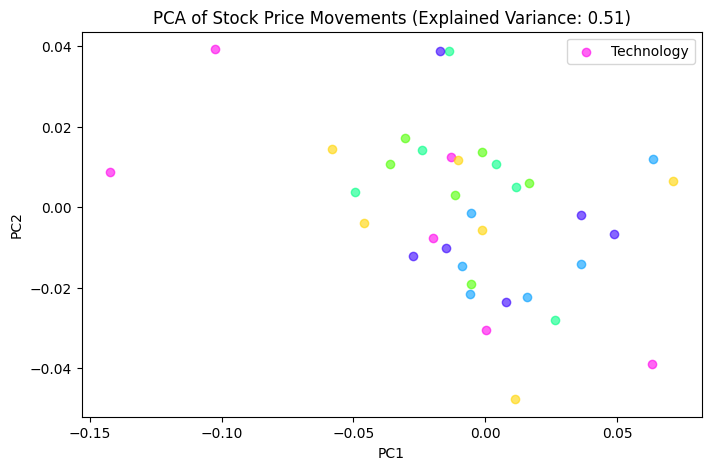

In [48]:
pca_analysis(stock_data_)

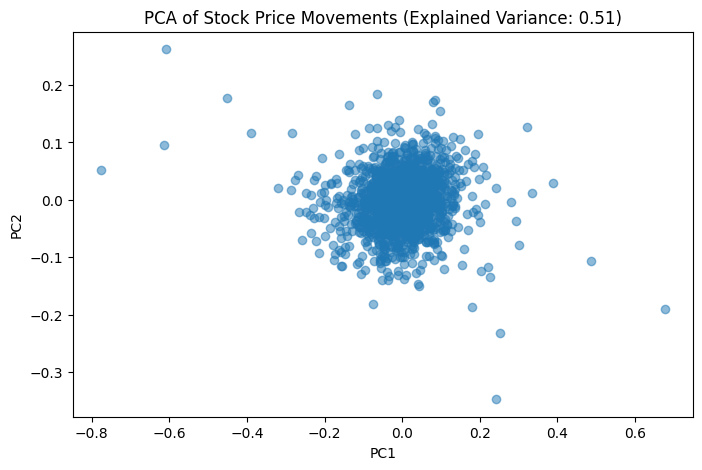

In [50]:
pca_analysis_1(stock_data_)

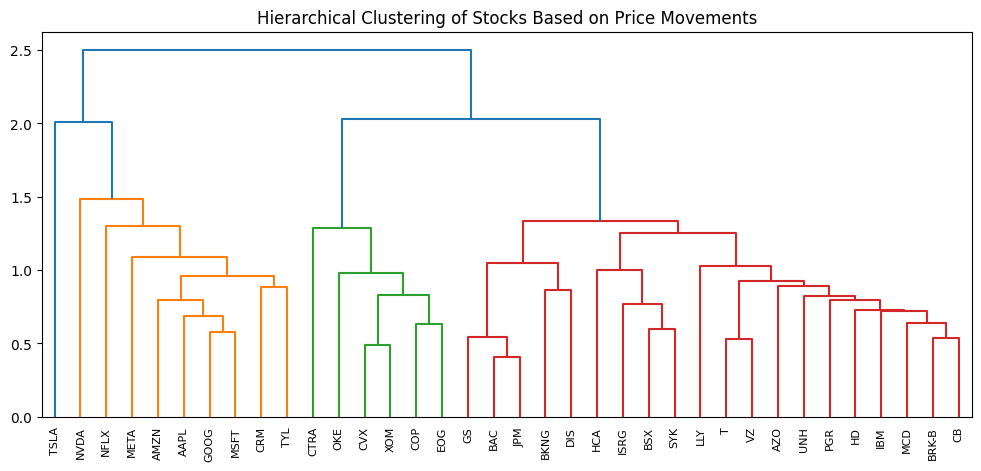

In [41]:
hierarchical_clustering(stock_data_)

In [51]:
sector_avg_trends = stock_data.groupby(['sector', 'date'])['close'].mean().unstack()
sector_avg_trends

date,2016-08-05,2016-08-08,2016-08-09,2016-08-10,2016-08-11,2016-08-12,2016-08-15,2016-08-16,2016-08-17,2016-08-18,2016-08-19,2016-08-22,2016-08-23,2016-08-24,2016-08-25,2016-08-26,2016-08-29,2016-08-30,2016-08-31,2016-09-01,2016-09-02,2016-09-05,2016-09-06,2016-09-07,2016-09-08,2016-09-09,2016-09-12,2016-09-13,2016-09-14,2016-09-15,2016-09-16,2016-09-19,2016-09-20,2016-09-21,2016-09-22,2016-09-23,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-31,2016-11-01,2016-11-02,2016-11-03,2016-11-04,2016-11-07,2016-11-08,2016-11-09,2016-11-10,2016-11-11,2016-11-14,2016-11-15,2016-11-16,2016-11-17,2016-11-18,2016-11-21,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-16,2017-01-17,2017-01-18,2017-01-19,2017-01-20,2017-01-23,2017-01-24,2017-01-25,2017-01-26,2017-01-27,2017-01-30,2017-01-31,2017-02-01,2017-02-02,2017-02-03,2017-02-06,2017-02-07,2017-02-08,2017-02-09,2017-02-10,2017-02-13,2017-02-14,2017-02-15,2017-02-16,2017-02-17,2017-02-20,2017-02-21,2017-02-22,2017-02-23,2017-02-24,2017-02-27,2017-02-28,2017-03-01,2017-03-02,2017-03-03,2017-03-06,2017-03-07,2017-03-08,2017-03-09,2017-03-10,2017-03-13,2017-03-14,2017-03-15,2017-03-16,2017-03-17,2017-03-20,2017-03-21,2017-03-22,2017-03-23,2017-03-24,2017-03-27,2017-03-28,2017-03-29,2017-03-30,2017-03-31,2017-04-03,2017-04-04,2017-04-05,2017-04-06,2017-04-07,2017-04-10,2017-04-11,2017-04-12,2017-04-13,2017-04-14,2017-04-17,2017-04-18,2017-04-19,2017-04-20,2017-04-21,2017-04-24,2017-04-25,2017-04-26,2017-04-27,2017-04-28,2017-05-01,2017-05-02,2017-05-03,2017-05-04,2017-05-05,2017-05-08,2017-05-09,2017-05-10,2017-05-11,2017-05-12,2017-05-15,2017-05-16,2017-05-17,2017-05-18,2017-05-19,2017-05-22,2017-05-23,2017-05-24,2017-05-25,2017-05-26,2017-05-29,2017-05-30,2017-05-31,2017-06-01,2017-06-02,2017-06-05,2017-06-06,2017-06-07,2017-06-08,2017-06-09,2017-06-12,2017-06-13,2017-06-14,2017-06-15,2017-06-16,2017-06-19,2017-06-20,2017-06-21,2017-06-22,2017-06-23,2017-06-26,2017-06-27,2017-06-28,2017-06-29,2017-06-30,2017-07-03,2017-07-04,2017-07-05,2017-07-06,2017-07-07,2017-07-10,2017-07-11,2017-07-12,2017-07-13,2017-07-14,2017-07-17,2017-07-18,2017-07-19,2017-07-20,...,2023-12-18,2023-12-19,2023-12-20,2023-12-21,2023-12-22,2023-12-25,2023-12-26,2023-12-27,2023-12-28,2023-12-29,2024-01-01,2024-01-02,2024-01-03,2024-01-04,2024-01-05,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19,2024-01-22,2024-01-23,2024-01-24,2024-01-25,2024-01-26,2024-01-29,2024-01-30,2024-01-31,2024-02-01,2024-02-02,2024-02-05,2024-02-06,2024-02-07,2024-02-08,2024-02-09,2024-02-12,2024-02-13,2024-02-14,2024-02-15,2024-02-16,2024-02-19,2024-02-20,2024-02-21,2024-02-22,2024-02-23,2024-02-26,2024-02-27,2024-02-28,2024-02-29,2024-03-01,2024-03-04,2024-03-05,2024-03-06,2024-03-07,2024-03-08,2024-03-11,2024-03-12,2024-03-13,2024-03-14,2024-03-15,2024-03-18,2024-03-19,2024-03-20,2024-03-21,2024-03-22,2024-03-25,2024-03-26,2024-03-27,2024-03-28,2024-03-29,2024-04-01,2024-04-02,2024-04-03,2024-04-04,2024-04-05,2024-04-08,2024-04-09,2024-04-10,2024-04-11,2024-04-12,2024-04-15,2024-04-16,2024-04-17,2024-04-18,2024-04-19,2024-04-22,2024-04-23,2024-04-24,2024-04-25,2024-04-26,2024-04-29,2024-04-30,2024-05-01,2024-05-02,2024-05-03,2024-05-06,2024-05-07,2024-05-08,2024-05-09,2024-05-10,2024-05-13,2024-05-14,2024-05-15,2024-05-16,2024-05-17,2024-05-20,2024-05-21,2024-05-2